In [1]:
import numpy as np
import random
from collections import Counter
from matplotlib import pyplot as plt
import networkx as nx
import scipy.linalg as la
from mpl_toolkits import mplot3d

import nltk
from nltk.corpus import brown
from sklearn import datasets

import fun as f
from pca import pca
from laplacian_eigenmaps import LE

## Laplacian Eigenmaps:
Trying to reproduce examples from: M. Belkin and P. Niyogi, "Laplacian Eigenmaps for Dimensionality Reduction and Data Representation," in Neural Computation, vol. 15, no. 6, pp. 1373-1396, 1 June 2003, doi: 10.1162/089976603321780317.

# Example: A Synthetic Swiss Roll

In [3]:
seed = 15783
np.random.seed(seed)  
n_samples = 2000
noise = 0.0
width = 100

u = np.random.uniform(0, 1, n_samples)
v = np.random.uniform(0, 1, n_samples)
t = 1.5 * np.pi * (1 + 2 * u)

x_s = t * np.cos(t)
y_s = width * v
z_s = t * np.sin(t)

coord_swiss_roll = np.vstack((x_s, y_s, z_s)).T
swiss_roll_colors = t
centered_swiss_roll = coord_swiss_roll - np.mean(coord_swiss_roll, 0)

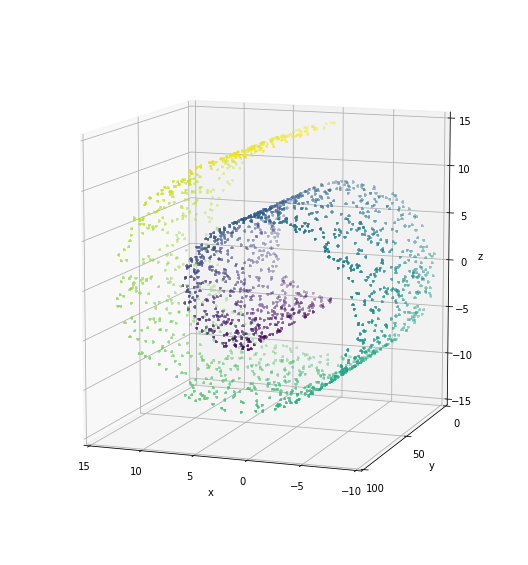

In [4]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter3D(x_s, y_s, z_s, c=t, marker = '+', s=10)
ax.set_xlim((-10,15))
ax.set_ylim((0,100))
ax.set_zlim((-15,15))
ax.set_yticks([ 0, 50, 100])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(10, 110)
plt.savefig('my_swiss_roll')
plt.show()

## Sanity check:

In [ ]:
# in the paper: L_rw -- > Ly = lambda D y
# in terms of L_sym --- > lamda , D^1/2 y || L_sym w = lambda w --> w = D^1/2 y

# ------- CTD embedding -----------------
# theta = sqrt(vol(G)) * A_sym^-1/2  * V^T_sym  * D^1/2

In [4]:
# some tests on the resulting coordinate system and graph: - sigma: np.sqrt(5/2) -
test_le = LE([5,5], nn_graph = 'knn', m = 2,  coord = coord_swiss_roll, sim_measure = 'gk')

## Verify the CTD on the graph matches the Eucledian distance on the new embedding: In terms of $L_{rw}$ and $L_{sym}$

In [5]:
## Eucledian Distance of the **complete** ctd coordinates:
sqrt_inv_Al = np.diag(1 / np.sqrt(np.asarray(test_le.eigenvalues_l[1:]) + 1e-10))
CTEl = np.dot( test_le.sqrtVol * sqrt_inv_Al, test_le.Vl_T)

sqrt_inv_D = np.diag(1 / np.sqrt(np.asarray(sum(test_le.A))[0]))
sqrt_inv_A = np.diag(1 / np.sqrt(np.asarray(test_le.eigenvalues_lrw[1:]) + 1e-10))
CTEsym = np.dot(test_le.sqrtVol * sqrt_inv_A, test_le.V_T).dot(sqrt_inv_D)

In [7]:
# takes a long time to compute #
ed_CTEl = np.zeros((n_samples, n_samples))
ed_CTElsym = np.zeros((n_samples, n_samples))
for xi in range(n_samples):
    for xj in range(xi, n_samples):
        ed_CTEl[xi, xj] = np.sqrt(sum((CTEl.T[xi] -  CTEl.T[xj])**2)) 
        ed_CTEl[xj, xi] = ed_CTEl[xi, xj]
        ed_CTElsym[xi, xj] = np.sqrt(sum((CTEsym.T[xi] - CTEsym.T[xj])**2)) 
        ed_CTElsym[xj, xi] = ed_CTElsym[xi, xj]

In [8]:
# takes a long time to compute #
## Commute time distance:
ctd_l = np.zeros((n_samples,n_samples))
ctd_lsym = np.zeros((n_samples,n_samples))
for i in range(n_samples):
    for j in range(i, n_samples):
        ed = (test_le.Vl_T[:,i] - test_le.Vl_T[:,j])**2
        ctd_ltemp = test_le.Vol * np.sum(( ed / test_le.eigenvalues_l[1:]))
        ctd_l[i,j] = ctd_ltemp
        ctd_l[j,i] = ctd_ltemp
        ed_sym = ((test_le.V_T[:,i] / np.sqrt(test_le.D[i,i])) - (test_le.V_T[:,j] / np.sqrt(test_le.D[j,j])))**2
        ctd_lsym_temp = test_le.Vol * np.sum((ed_sym / test_le.eigenvalues_lsym[1:]))        
        ctd_lsym[i,j] = ctd_lsym_temp
        ctd_lsym[j,i] = ctd_lsym_temp
        

In [9]:
print(np.mean(np.isclose(ed_CTEl, np.sqrt(ctd_l))))
print(np.mean(np.isclose(ed_CTElsym,np.sqrt(ctd_lsym))))

1.0
1.0


## Reproduce Figure 2: Two-dimensional representations of the swiss roll data, for different values of the number of nearest neighbors N and the heat kernel parameter t.

In [5]:
parms_list = [[5, 5], [10, 5], [15, 5], 
              [5, 25], [10, 25], [15, 25], 
              [5, np.infty], [10, np.infty], [15, np.infty]]
res = {}
for idx, set_parms in enumerate(parms_list):
    N, t = set_parms
    print(f'par: k = {N}, t = {t}', sep = " ")
    le_swiss_roll = LE(par = set_parms, nn_graph = 'knn', m=2, coord = coord_swiss_roll, sim_measure = 'gk')
    res[idx] = le_swiss_roll

par: k = 5, t = 5
par: k = 10, t = 5
par: k = 15, t = 5
par: k = 5, t = 25
par: k = 10, t = 25
par: k = 15, t = 25
par: k = 5, t = inf
par: k = 10, t = inf
par: k = 15, t = inf


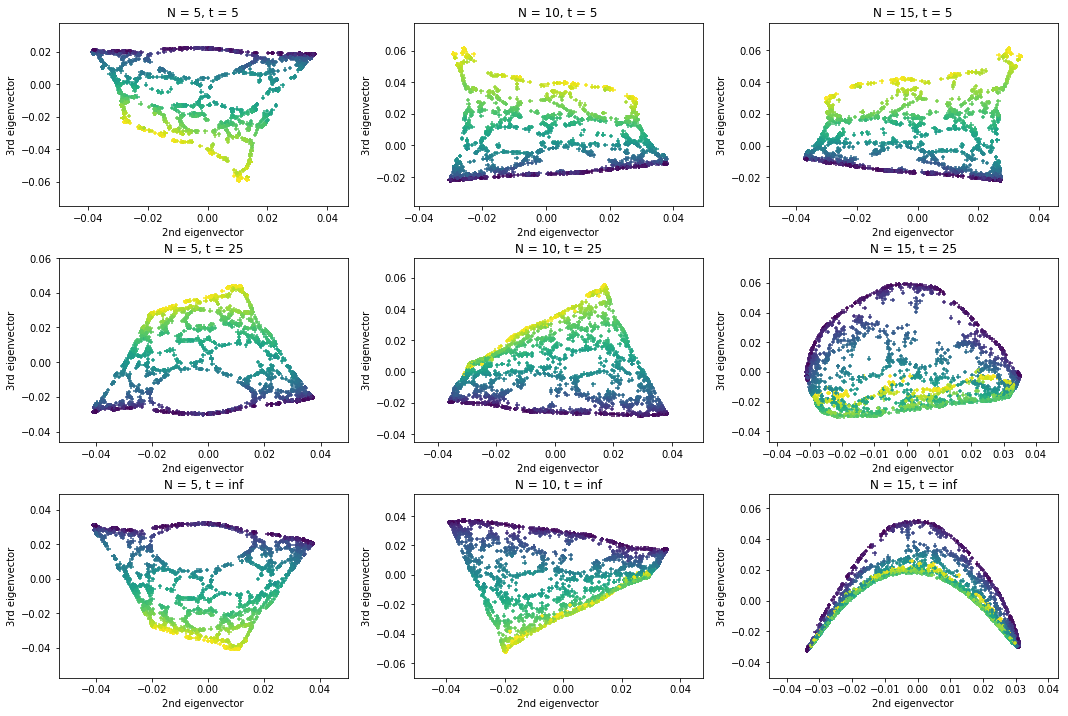

In [6]:
fig = plt.figure(figsize=(15, 11))
for keys, values in res.items():
    plt.subplot(3, 3, keys + 1)
    plt.tight_layout()
    plt.xlabel('2nd eigenvector')
    plt.ylabel('3rd eigenvector')
    fig.subplots_adjust(top = 0.88)
    plt.scatter(values.eigenvectors_lrw[1], values.eigenvectors_lrw[2],
                c = swiss_roll_colors, marker = '+', s = 20)
    plt.title("N = " + str(parms_list[keys][0]) + ", t = " + str(parms_list[keys][1]))
#plt.savefig('laplacian_eigenm_norm_lap')
plt.show()

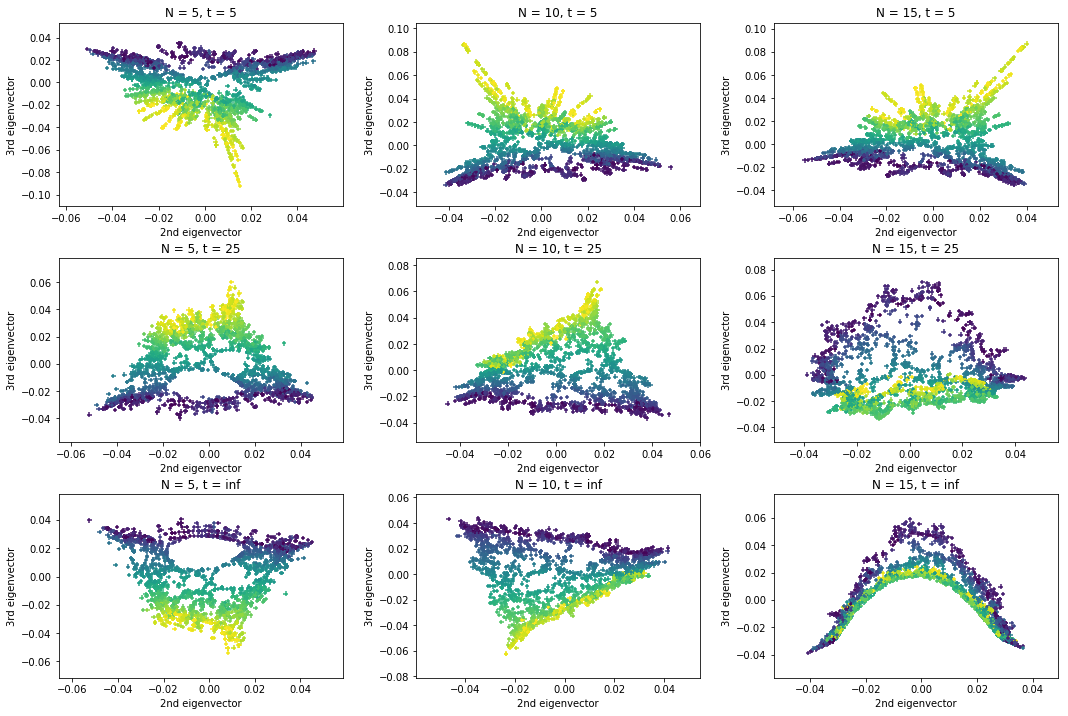

In [7]:
fig = plt.figure(figsize=(15, 11))
for keys, values in res.items():
    plt.subplot(3, 3, keys + 1)
    plt.tight_layout()
    plt.xlabel('2nd eigenvector')
    plt.ylabel('3rd eigenvector')
    fig.subplots_adjust(top = 0.88)
    plt.scatter(values.eigenvectors_lsym[1], values.eigenvectors_lsym[2],
                c = swiss_roll_colors, marker = '+', s = 20)
    plt.title("N = " + str(parms_list[keys][0]) + ", t = " + str(parms_list[keys][1]))
#plt.savefig('laplacian_eigenm_norm_lap')
plt.show()

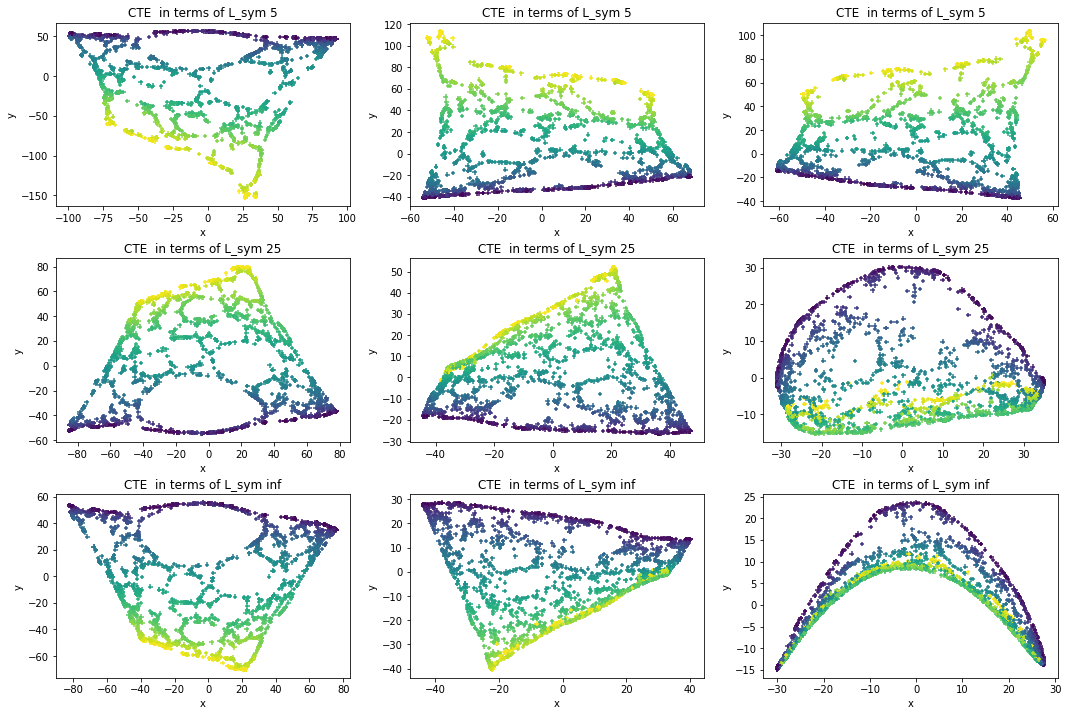

In [8]:
fig = plt.figure(figsize=(15, 11))
for keys, values in res.items():
    plt.subplot(3, 3, keys + 1)
    plt.tight_layout()
    plt.xlabel('x')
    plt.ylabel('y')
    fig.subplots_adjust(top = 0.88)
    plt.scatter(values.CTE[0], values.CTE[1], c = swiss_roll_colors, marker = '+', s = 20)
    plt.title("CTE  in terms of L_sym "+ str(parms_list[keys][1]))
plt.savefig('laplacian_eigenm_norm_ctd')
plt.show()

## Same experiments but using the inverse eucledian distance to weight the graphs' edges

In [9]:
par_list = [5, 10, 15]
res_ie = {}
for idx, par in enumerate(par_list):
    print(f'par: k = {par} ', sep = " ")
    le_swiss_roll = LE(par = par, nn_graph = 'knn', m=2, coord = coord_swiss_roll, sim_measure = 'inv_ed')
    res_ie[idx] = le_swiss_roll

par: k = 5 
par: k = 10 
par: k = 15 


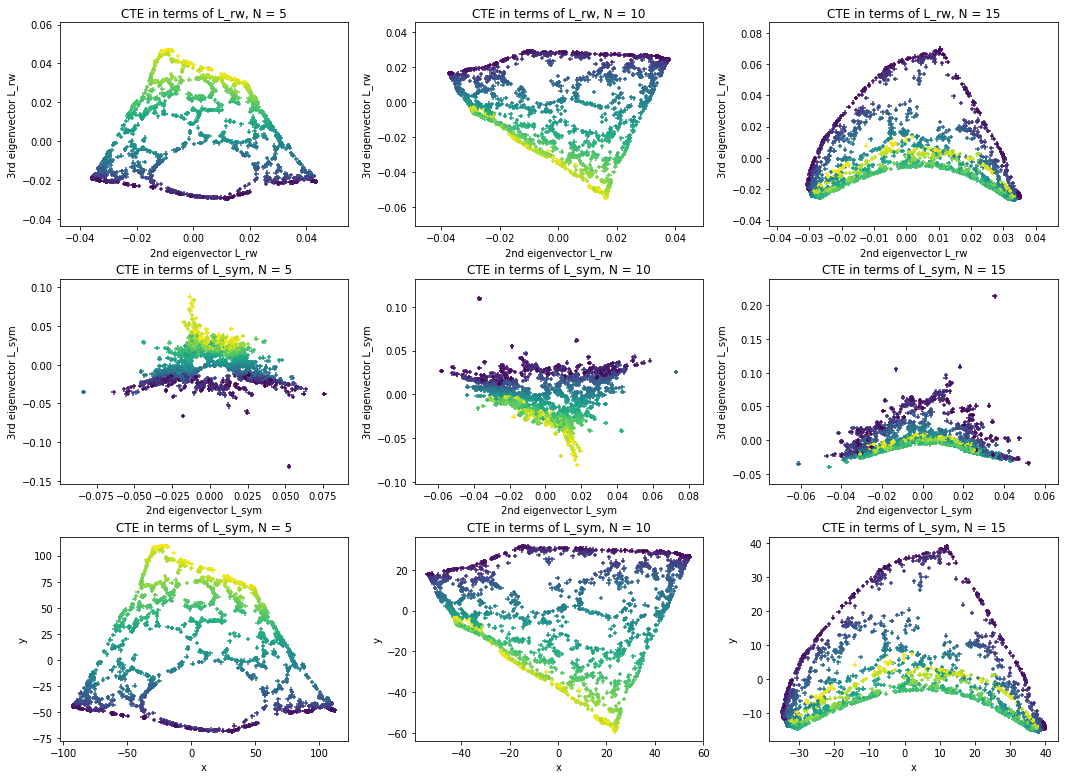

In [13]:
fig = plt.figure(figsize=(15, 12))
for keys, values in res_ie.items():
    plt.subplot(3, 3, keys + 1)
    plt.tight_layout()
    plt.xlabel('2nd eigenvector L_rw')
    plt.ylabel('3rd eigenvector L_rw')
    fig.subplots_adjust(top = 0.88)
    plt.scatter(values.eigenvectors_lrw[1], values.eigenvectors_lrw[2],
                c = swiss_roll_colors, marker = '+', s = 20)
    plt.title(f'CTE in terms of L_rw, N = {par_list[keys]}')
    plt.subplot(3, 3, 3 + keys + 1)
    plt.tight_layout()
    plt.xlabel('2nd eigenvector L_sym')
    plt.ylabel('3rd eigenvector L_sym')
    fig.subplots_adjust(top = 0.88)
    plt.scatter(values.eigenvectors_lsym[1], values.eigenvectors_lsym[2],
                c = swiss_roll_colors, marker = '+', s = 20)
    plt.title(f'CTE in terms of L_sym, N = {par_list[keys]}')
    plt.subplot(3, 3, 6 + keys + 1)
    plt.tight_layout()
    plt.xlabel('x')
    plt.ylabel('y')
    fig.subplots_adjust(top = 0.88)
    plt.scatter(values.CTE[0], values.CTE[1],
                c = swiss_roll_colors, marker = '+', s = 20)
    plt.title(f'CTE in terms of L_sym, N = {par_list[keys]}')
plt.show()

# Example: A Linguistic Example - Brown corpus -

In [14]:
words_brown = []
brown_text = []

for category in brown.categories():
    words_brown.append([word for word in brown.tagged_words(categories=category)])
    brown_text.append(brown.sents(categories = category))

words_brown_list = [words for category_words in words_brown for words in category_words]
text_brown_list = [sentences for category in brown_text for sentences in category]

In [15]:
print(text_brown_list[0:5])

[['Dan', 'Morgan', 'told', 'himself', 'he', 'would', 'forget', 'Ann', 'Turner', '.'], ['He', 'was', 'well', 'rid', 'of', 'her', '.'], ['He', 'certainly', "didn't", 'want', 'a', 'wife', 'who', 'was', 'fickle', 'as', 'Ann', '.'], ['If', 'he', 'had', 'married', 'her', ',', "he'd", 'have', 'been', 'asking', 'for', 'trouble', '.'], ['But', 'all', 'of', 'this', 'was', 'rationalization', '.']]


In [16]:
N_most_common_words = 344
most_common_N = Counter(words_brown_list).most_common(N_most_common_words)
words = [most_common_N[i][0][0] for i in range(len(most_common_N))]
words_list = []
for word in words:
    if word not in words_list and word not in [':', ';', '.', '-', ',',
                                               ' " ', '``', "''", '?',
                                               '--', ')', '(', '!', "'", '1']:
        words_list.append(word)
#words_labels = [most_common_N[i][0][1] for i in range(len(most_common_N))]

In [17]:
len(words_list)

300

In [18]:
V_matrix = np.zeros((300, 300 * 2))
for idx_word, word_i in enumerate(words_list):
    pair_word_i = [[(word_j, word_i) for word_j in  words_list],[(word_i, word_j) for word_j in words_list]]
    pair_wordi_flatten = [words_pair for comb in pair_word_i for words_pair in comb]
    word_encode_vector = [0] * len(pair_wordi_flatten)
    for sentence in text_brown_list:
        if (len(sentence) > 1) and (word_i in sentence):
            last_idx = len(sentence) - 1
            word_in_sentence_idx = [idx for idx, word in enumerate(sentence) if word == word_i]
            pair_words_sentence = [[(sentence[(idx - 1)], sentence[idx]),
                                    (sentence[idx], sentence[idx+1])]
                                   for idx in  [idx for idx in word_in_sentence_idx 
                                                if idx not in [0, last_idx]] ]
            #flatten list
            pair_words_sentence =[pair_words for l in pair_words_sentence for pair_words in l]
            
            if 0 in word_in_sentence_idx:
                pair_words_sentence.append((sentence[0], sentence[1]))
            
            if last_idx in word_in_sentence_idx:
                pair_words_sentence.append((sentence[last_idx-1], sentence[last_idx]))
                   
            for sentence_pair_words in pair_words_sentence:
                if sentence_pair_words in pair_wordi_flatten:
                    word_encode_vector[pair_wordi_flatten.index(sentence_pair_words)] +=1
    V_matrix[idx_word,] = word_encode_vector

In [20]:
le_brown = LE([14, np.infty], nn_graph = 'knn', coord = V_matrix, m=2, sim_measure = 'gk')

In [21]:
print(words_list[0:10])

['the', 'of', 'and', 'a', 'in', 'to', 'is', 'was', 'for', 'with']


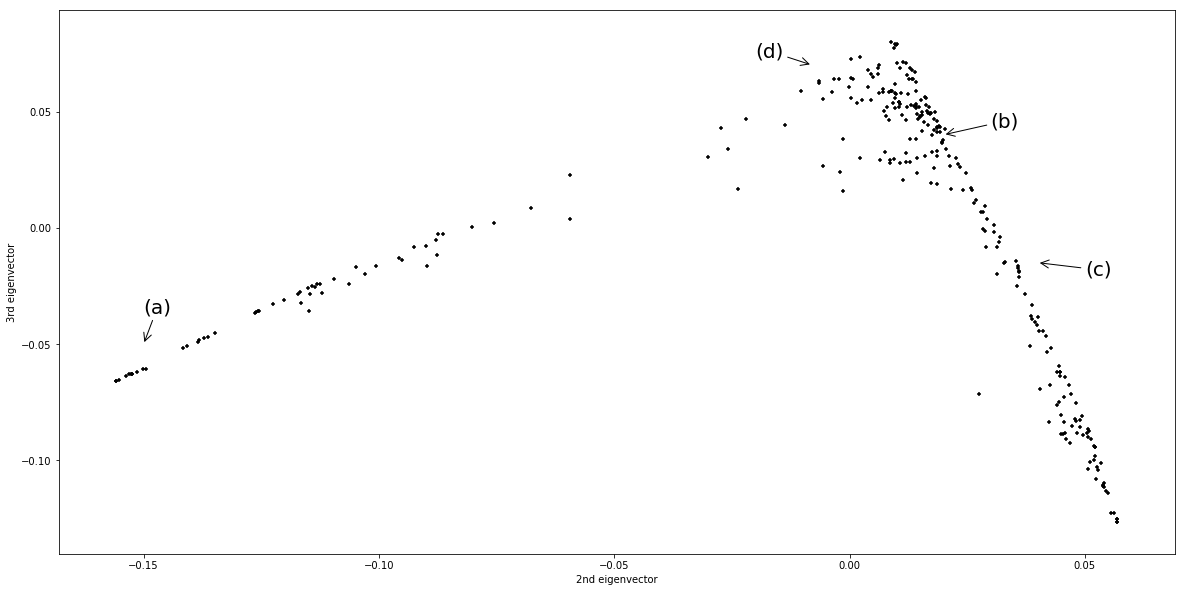

In [23]:
fig, ax = plt.subplots(1,1,figsize=(20,10))
ax.scatter( le_brown.eigenvectors_lrw[1], -le_brown.eigenvectors_lrw[2], marker = '+', s=10, c= 'black')
ax.annotate('(a)', xy=(-0.15, -0.05), xytext=(-0.15,-0.03), arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            horizontalalignment='left', verticalalignment='top',size=20)

ax.annotate('(b)', xy=(0.02, 0.04), xytext=(0.030,0.05), arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            horizontalalignment='left', verticalalignment='top',size=20)
ax.annotate('(c)', xy=(0.04, -0.015), xytext=(0.050,-0.014), arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            horizontalalignment='left', verticalalignment='top',size=20)
ax.annotate('(d)', xy=(-0.008, 0.070), xytext=(-0.02,0.08), arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"),
            horizontalalignment='left', verticalalignment='top',size=20)
ax.set_xlabel('2nd eigenvector')
ax.set_ylabel('3rd eigenvector')
#plt.savefig('spectral_domain_brown')
plt.show()

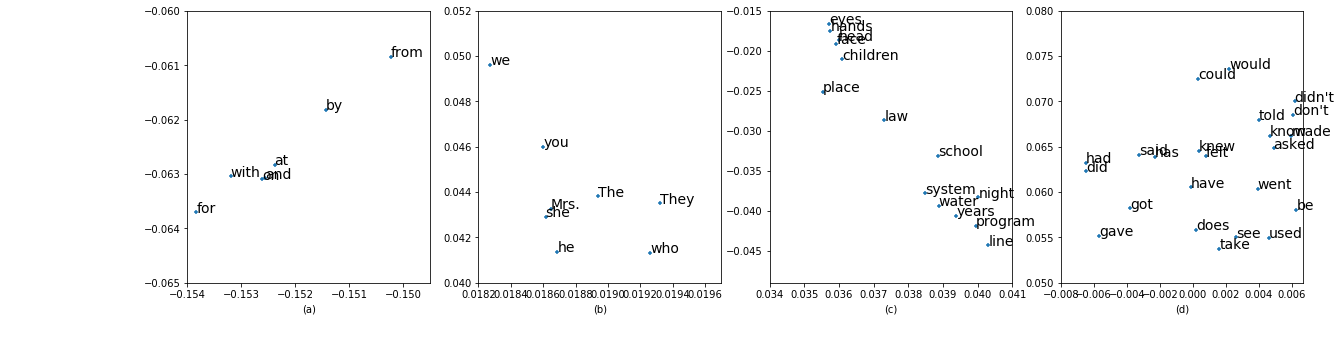

In [24]:

x_lims = [(-0.154, -0.1495), (0.0182, 0.0197), (0.034, 0.041),  (-0.008, 0.0067)]
y_lims = [(-0.065, -0.06), (0.04, 0.052), (-0.049, -0.015), (0.05, 0.08)]
lables = ['(a)', '(b)', '(c)', '(d)']

fig, ax = plt.subplots(1,4,figsize=(20,5))
for i in range(len(x_lims)):
    ax[i].scatter(le_brown.eigenvectors_lrw[1], -le_brown.eigenvectors_lrw[2], marker = '+', s=20)
    ax[i].set_xlim(x_lims[i])
    ax[i].set_ylim(y_lims[i])
    ax[i].set_xlabel(lables[i])
    for j, word in enumerate(words_list):
        ax[i].annotate(word, (le_brown.eigenvectors_lrw[1][j], -le_brown.eigenvectors_lrw[2][j]), size=14)
#plt.savefig('zoomin_brown_corpus')
plt.show() 

In [ ]:
# # Symmetry of L_unnorm
# print(np.sum(test_le.L_unnorm,0))
# # print(np.sum(np.sum(test_le.L_unnorm,0)))
# print(np.sum(test_le.L_unnorm,1).T)
# # print(np.sum(np.sum(test_le.L_unnorm,1).T))

# #Sanity check:
# print(np.dot(test_le.eigenvectors_lrw[1],test_le.eigenvectors_lrw[1]))
# print(np.dot(test_le.eigenvectors_lrw[1],test_le.eigenvectors_lrw[0]))

# #Symmetry of L_sym
# print(np.sum(test_le.L_symm,0))
# #print(np.sum(np.sum(test_le.L_symm,0)))
# print(np.sum(test_le.L_symm,1).T)
# #print(np.sum(np.sum(test_le.L_symm,1).T))

# #Sanity check:
# print(np.dot(test_le.eigenvectors_l[1], test_le.eigenvectors_l[1]))
# print(np.dot(test_le.eigenvectors_l[1], test_le.eigenvectors_l[0]))


# #Sanity check:
# print(np.dot(test_le.eigenvectors[1], test_le.eigenvectors[1]))
# print(np.dot(test_le.eigenvectors[1], test_le.eigenvectors[0]))
